# Testing of various expt design types

In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
import pandas as pd
import numpy as np

import darc
from darc.delayed import models
from darc.designs import DARCDesign
from darc.delayed.designs import Griskevicius2011delay, Frye, Koffarnus_Bickel, Kirby2009

from darc.data_plotting import plot_delay_without_front_end_delays
from darc_parameter_recovery import simulated_experiment_trial_loop

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Posterior predictive plotting function

In [3]:
def hyperbolic_discount_func(delay, logk):
    k = np.exp(logk)
    return np.divide(1, (1 + k * delay))

def hyperbolic_posterior_predictive(ax, fitted_model):
    logk = fitted_model.θ['logk'].values  # get posterior samples
    delays = np.linspace(0, 365, 500)
    logk_percentiles = np.percentile(logk,[2.5, 50, 100-2.5])    
    
    y_upper = hyperbolic_discount_func(delays, logk_percentiles[2])
    y_median = hyperbolic_discount_func(delays, logk_percentiles[1])
    y_lower = hyperbolic_discount_func(delays, logk_percentiles[0])

    ax.fill_between(delays, y_lower, y_upper, alpha=0.3, label='95% CI')
    ax.plot(delays, y_median, label='posterior median')
    ax.legend()

## Run simulated experiments

In [4]:
true_params = [pd.DataFrame.from_dict({'logk': [np.log(0.04)], 'α': [2]}),
               pd.DataFrame.from_dict({'logk': [np.log(0.01)], 'α': [2]}),
               pd.DataFrame.from_dict({'logk': [np.log(0.0028)], 'α': [2]})]

col_titles = ['major depressive disorder', 'upper income adult', 'anorexia nervosa']

BAD = lambda: DARCDesign(max_trials=20, 
                         RA=list(np.arange(5, 99+1, 1)), 
                         DB=list(np.arange(1, 365, 7)))

design_types = [Kirby2009, 
                Griskevicius2011delay, 
                Koffarnus_Bickel, 
                Frye,
                BAD]

row_headings = ['Kirby (2009)',
                'Griskevicius\n et al (2011)',
                'Koffarnus & Bickel\n (2014)',
                'Frye et al (2016)',
                'our approach']

/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:153: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled+n_times_sampled_iter))
/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:226: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled + n_times_sampled_iter))


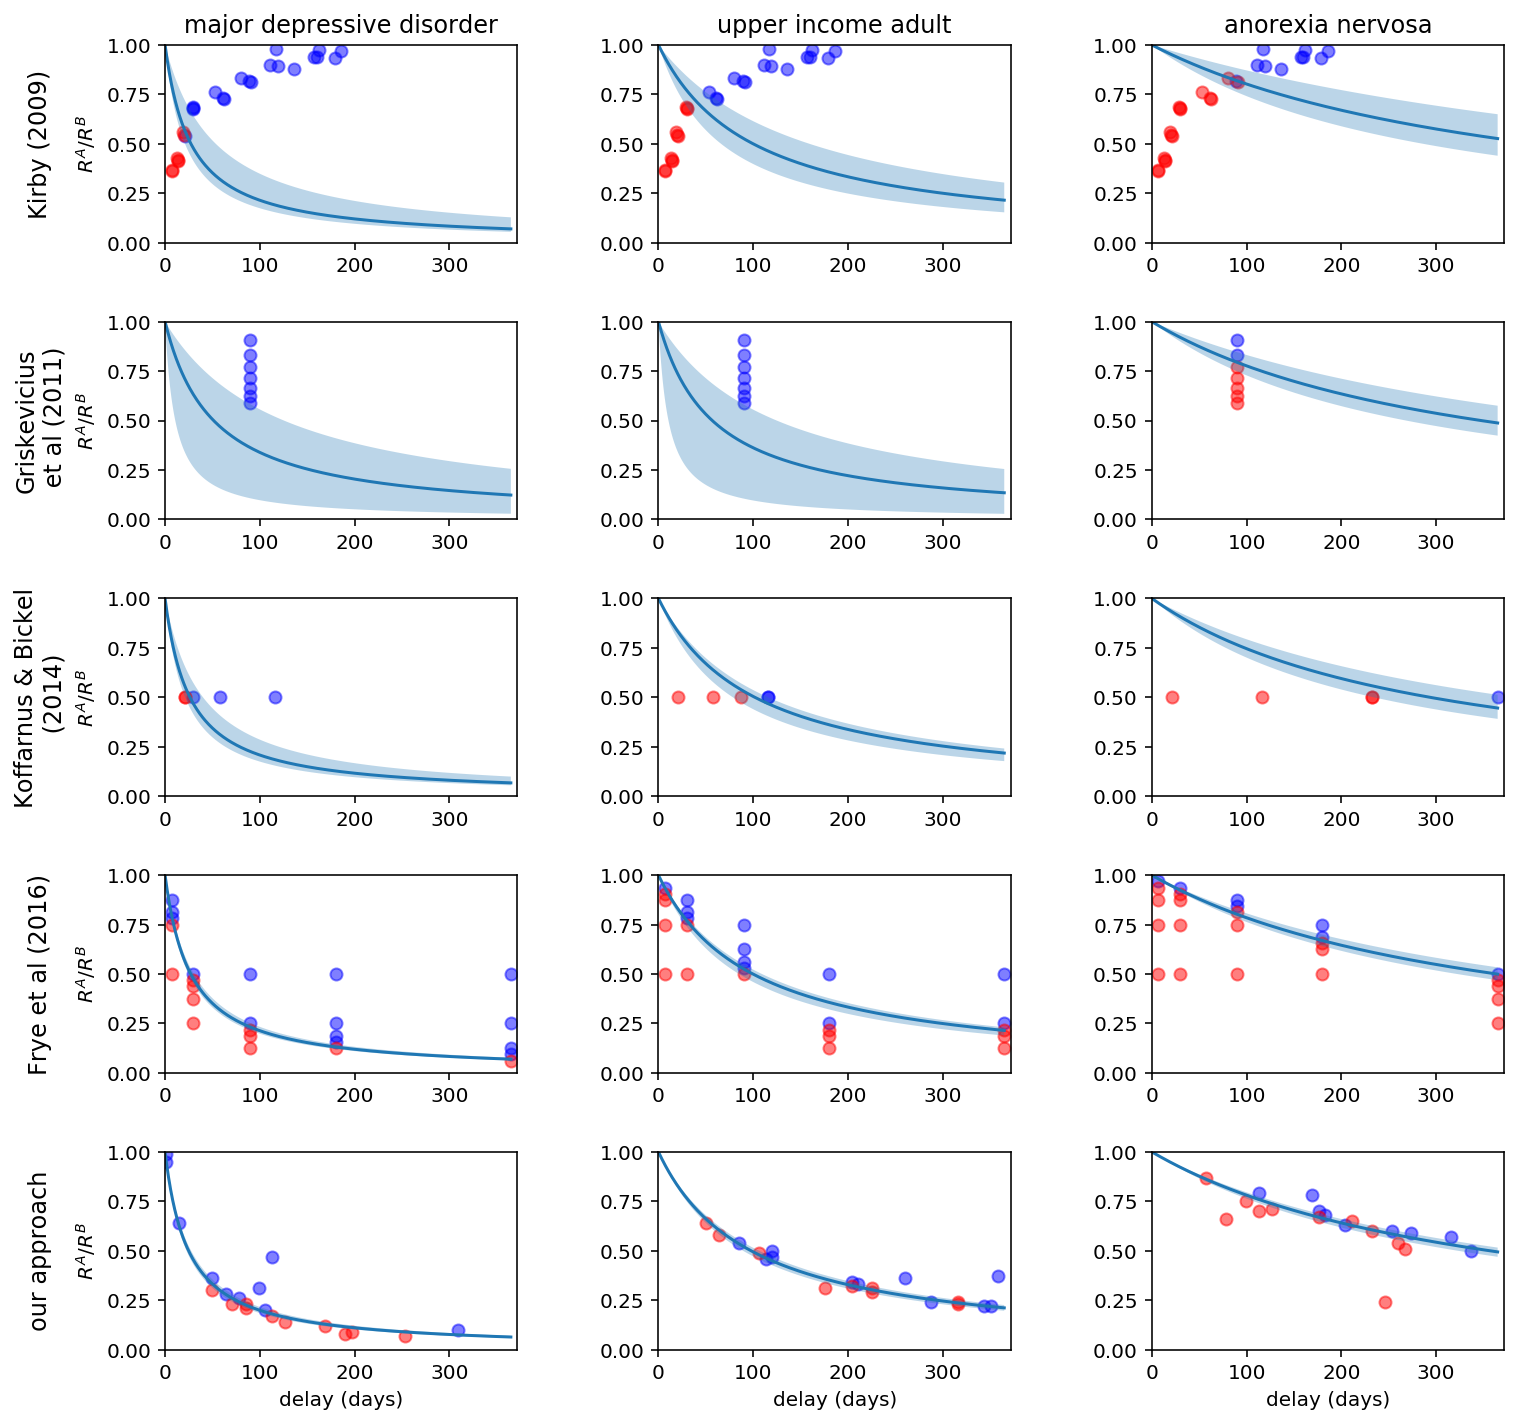

In [6]:
fig, ax = plt.subplots(len(design_types), len(true_params), figsize=(12, 12))

for col, true_p in enumerate(true_params):
    for row, designfunc in enumerate(design_types):
        design_thing = designfunc()
        model = models.Hyperbolic(n_particles=5000)
        model.θ_true = pd.DataFrame.from_dict(true_p)
        fitted_model, _ = simulated_experiment_trial_loop(design_thing, model)
        plot_delay_without_front_end_delays(ax[row,col], design_thing.all_data)
        hyperbolic_posterior_predictive(ax[row,col], fitted_model)
        
        if col > 0:
            ax[row,col].set_ylabel('')
        
        if row < len(design_types)-1:
            ax[row,col].set_xlabel('')

plt.subplots_adjust(hspace=0.4, wspace=0.4)

[ax[r,c].set_xlim([0, 365+7]) for r in range(len(design_types)) for c in range(len(true_params))]
[ax[r,c].set_ylim([0, 1]) for r in range(len(design_types)) for c in range(len(true_params))]
[ax[0,c].set_title(title) for c, title in enumerate(col_titles)]
[ax[r,c].get_legend().remove() for r in range(len(design_types)) for c in range(len(true_params))]

pad = 13 # in points
for axis, row_title in zip(ax[:,0], row_headings):
    axis.annotate(row_title, xy=(0, 0.5), xytext=(-axis.yaxis.labelpad - pad, 0),
                  xycoords=axis.yaxis.label, textcoords='offset points',
                  size='large', ha='center', va='center', rotation=90)
    
    
fig.savefig('logk_comparison_of_expt_types.pdf', bbox_inches='tight')